In [2]:
import matplotlib.pyplot as plt

from pymongo import MongoClient
import math
import numpy as np
from bson import ObjectId

host = "localhost:27017"
database = "greenpeace"
dbClient = MongoClient(host)
db = dbClient[database]

In [34]:
data = {}
data["avg"] = {}
data["rng"] = {}

for year in range(2005, 2017):
    for month in range(5, 9):
        res = db["ozone"].aggregate(
            [
                {"$project": {"_id": 0, "value": 1, "year": {"$year": "$date"}, "month": {"$month": '$date'}, "loc": 1, "tag": 1}},
                {"$match": {"year": year, "month": month}},
                {
                    "$group": {
                        "_id": "$tag",
                        "avg": { "$avg": "$value" },
                        "max": { "$max": "$value" },
                        "min": { "$min": "$value" }
                    }
                },
                {"$project": {
                    "_id": 1,
                    "valueRange": {
                        "$subtract": [ "$max", "$min" ] 
                    } ,
                    "avg": 1
                }}
           ]
        )
        for d_ in res:
            try:
                data["avg"][d_["_id"]] += [d_["avg"]]
                data["rng"][d_["_id"]] += [d_["valueRange"]]
            except:
                data["avg"][d_["_id"]] = []
                data["avg"][d_["_id"]] += [d_["avg"]]
                data["rng"][d_["_id"]] = []
                data["rng"][d_["_id"]] += [d_["valueRange"]]

In [35]:
import pickle
pickle.dump(data, open("summertime_data.pickle", "wb"))

In [131]:
data = pickle.load(open("summertime_data.pickle", "rb"))

## Visualizations
> This code is able to plot multiple lines, but messy. So read on.

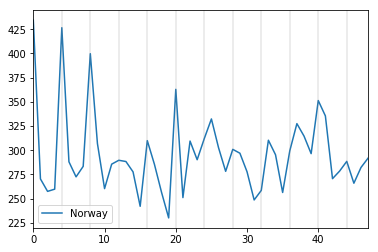

In [81]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
import matplotlib.pyplot as plt
plt.figure(figsize=(12,60))

how_many_lines_to_show = 1
frame = DataFrame()
counter = 0
for key in data["avg"].keys():
    frame[key] = data["avg"][key]
    counter += 1
    if counter == how_many_lines_to_show:
        break

frame.plot(subplots=False, legend=True)
vlines = np.arange(4, 48, 4)
for vl in vlines:
    plt.axvline(vl, c="grey", alpha=0.2)
plt.show()

## Simply do a linear regression to check which country has the largest summertime ozone increase across the 12 years

In [90]:
slope_record = {}
for key in data["avg"].keys():
    d = data["avg"][key]
    
    yearly_data = []
    for year in range(0, 12):
        season_indexes = [4 * year, 4 * year + 1, 4 * year + 2, 4 * year + 3]
        yearly_data_ = []
        for ind in season_indexes:
            yearly_data_ += [data["avg"][key][ind]]
        yearly_data += [np.mean(yearly_data_)]

    x = np.arange(0, 12)
    y = yearly_data
    slope = np.polyfit(x, y, 1)[0]
    slope_record[key] = slope

In [95]:
sorted_country_list = []
for country in sorted(slope_record, key=slope_record.get):
    sorted_country_list += [country]
    print("Country: {}; slope: {}".format(country, slope_record[country]))

Country: French Southern and Antarctic Lands; slope: -7.716783216783211
Country: Chile; slope: -1.1585260892953282
Country: Norway; slope: -1.0394605394605212
Country: Nepal; slope: -0.8367768595041342
Country: Sweden; slope: -0.029260213470730503
Country: Moldova; slope: 0.10052447552447955
Country: Paraguay; slope: 0.34265734265733827
Country: Papua New Guinea; slope: 0.6304557511454062
Country: Argentina; slope: 0.6354973501834492
Country: Albania; slope: 0.7058566433566579
Country: Uruguay; slope: 0.7364510489510544
Country: Laos; slope: 0.8238090034965105
Country: Bulgaria; slope: 0.8396376350921912
Country: East Timor; slope: 0.865384615384613
Country: Belarus; slope: 0.9178321678321677
Country: Bolivia; slope: 0.932030807030814
Country: Australia; slope: 0.9504274899248006
Country: Belgium; slope: 0.9536713286713346
Country: Greece; slope: 0.9766899766899728
Country: Portugal; slope: 0.9977054195804387
Country: Macedonia; slope: 1.0472027972028128
Country: Colombia; slope: 1.053

## Check what happend in some countries
> This shows the 5 countries that shows larger decrease of ozone levels

In [133]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
import matplotlib.pyplot as plt

how_many_lines_to_show = 3
ctry_list = sorted_country_list[:how_many_lines_to_show]
frame = DataFrame()

for i in ctry_list:
    frame[i] = data["avg"][i]

frame.plot(subplots=False, legend=True)
vlines = np.arange(4, 48, 4)
for vl in vlines:
    plt.axvline(vl, c="grey", alpha=0.2)
plt.show()

> And, this shows the 5 countries that shows larger increase of ozone levels 

In [134]:
from pandas import Series
from pandas import DataFrame
from pandas import TimeGrouper
import matplotlib.pyplot as plt

how_many_lines_to_show = 3
ctry_list = sorted_country_list[-how_many_lines_to_show:]
frame = DataFrame()

for i in ctry_list:
    frame[i] = data["avg"][i]

frame.plot(subplots=False, legend=True)
vlines = np.arange(4, 48, 4)
for vl in vlines:
    plt.axvline(vl, c="grey", alpha=0.2)
plt.show()

## Using the same method, but to extract the regions that shows largest increase or decrease of ozone levels

In [140]:
data = {}

for year in range(2005, 2017):
    for month in range(5, 9):
        res = db["ozone"].aggregate(
            [
                {"$project": {"_id": 0, "value": 1, "year": {"$year": "$date"}, "month": {"$month": '$date'}, "loc.coordinates": 1}},
                {"$match": {"year": year, "month": month}},
                {"$project": {
                    "_id": 0,
                    "value": 1,
                    "loc.coordinates": 1
                }}
           ]
        )
        for d_ in res:
            try:
                data[tuple(d_["loc"]["coordinates"])] += [d_["value"]]
            except:
                data[tuple(d_["loc"]["coordinates"])] = []
                data[tuple(d_["loc"]["coordinates"])] += [d_["value"]]


In [141]:
import pickle
pickle.dump(data, open("all_location_data.pickle", "wb"))

In [138]:
data = pickle.load(open("all_location_data.pickle", "rb"))

In [142]:
slope_record = {}
for key in data.keys():
    d = data[key]
    
    yearly_data = []
    for year in range(0, 12):
        season_indexes = [4 * year, 4 * year + 1, 4 * year + 2, 4 * year + 3]
        yearly_data_ = []
        for ind in season_indexes:
            yearly_data_ += [data[key][ind]]
        yearly_data += [np.mean(yearly_data_)]

    x = np.arange(0, 12)
    y = yearly_data
    slope = np.polyfit(x, y, 1)[0]
    slope_record[key] = slope


> This shows the 10 regions (and their enclosing country, if there is) that show largest ozone decrease for the 12 years.

In [147]:
sorted_location_list = []
for idx, loc in enumerate(sorted(slope_record, key=slope_record.get)):
    sorted_location_list += [loc]
    
    country = db["countries"].find_one({
        "geometry": {
            "$geoIntersects": {
                "$geometry": {
                    "type": "Point", "coordinates": list(loc)
                }
            }
        }
    })
    if country is None:
        tag = "n/a"
    else:
        tag = country["properties"]["name"]    
    if idx < 10:
        print("location: {}; country: {}; slope: {}".format(loc, tag, slope_record[loc]))
    else:
        break

location: (-73.125, -48.5); country: Chile; slope: -76.11800699300697
location: (-70.625, -36.5); country: Argentina; slope: -54.5506993006993
location: (-70.625, -35.5); country: Chile; slope: -48.4326923076923
location: (-136.875, 59.5); country: Canada; slope: -35.217657342657326
location: (-138.125, 59.5); country: Canada; slope: -26.579545454545432
location: (-76.875, 2.5); country: Colombia; slope: -26.561188811188785
location: (139.375, -4.5); country: Indonesia; slope: -26.397727272727284
location: (-71.875, -48.5); country: Argentina; slope: -22.740384615384624
location: (79.375, -59.5); country: n/a; slope: -22.645104895104883
location: (-135.625, 59.5); country: United States of America; slope: -22.43356643356643


> This shows the 10 regions (and their enclosing country, if there is) that show largest ozone increase for the 12 years.

In [148]:
sorted_location_list = []
for idx, loc in enumerate(sorted(slope_record, key=slope_record.get, reverse=True)):
    sorted_location_list += [loc]
    
    country = db["countries"].find_one({
        "geometry": {
            "$geoIntersects": {
                "$geometry": {
                    "type": "Point", "coordinates": list(loc)
                }
            }
        }
    })
    if country is None:
        tag = "n/a"
    else:
        tag = country["properties"]["name"]    
    if idx < 10:
        print("location: {}; country: {}; slope: {}".format(loc, tag, slope_record[loc]))
    else:
        break

location: (-165.625, 50.5); country: n/a; slope: 21.73076923076924
location: (-164.375, 49.5); country: n/a; slope: 18.5270979020979
location: (-78.125, 0.5); country: Ecuador; slope: 18.326048951048993
location: (176.875, 48.5); country: n/a; slope: 17.52972027972029
location: (-15.625, -58.5); country: n/a; slope: 17.421328671328673
location: (-164.375, 50.5); country: n/a; slope: 16.71678321678322
location: (-16.875, -58.5); country: n/a; slope: 16.681818181818173
location: (-76.875, -9.5); country: Peru; slope: 15.38636363636364
location: (-78.125, 56.5); country: n/a; slope: 15.367132867132865
location: (-178.125, 49.5); country: n/a; slope: 15.251748251748252


## Save csv file for importing to CartoDB

In [ ]:
with open("dataset/may05.csv", "w") as f:
    for r in res:
        f.write(str(r["loc"]["coordinates"][0]) + "," + str(r["loc"]["coordinates"][1]) + "," + str(r["value"]) + "\n")